# predictions & weight saving

----

this notebook is to make sure that the ssim net is saving the weights in a way that we can recreate the network easily. 

In [1]:
import numpy as np
import pandas as pd
import scipy.signal as sig
import matplotlib.pyplot as plt
import iqa_tools as iqa
import matplotlib.gridspec as gridspec
import tensorflow as tf

In [10]:
image_dim, result_dim = 96, 86
input_layer, output_layer = 4, 1
input_layer, first_layer, second_layer, third_layer, fourth_layer, output_layer = 4, 100, 50, 25, 10, 1
filter_dim, filter_dim2 = 11, 1

In [2]:
data_path = '/home/dirty_mike/Dropbox/github/image_quality_analysis/data/sample_data/'
train_features, train_target, test_features, test_target = iqa.load_data(local=True, path=data_path)

In [3]:
train_features.shape

(500, 96, 96, 4)

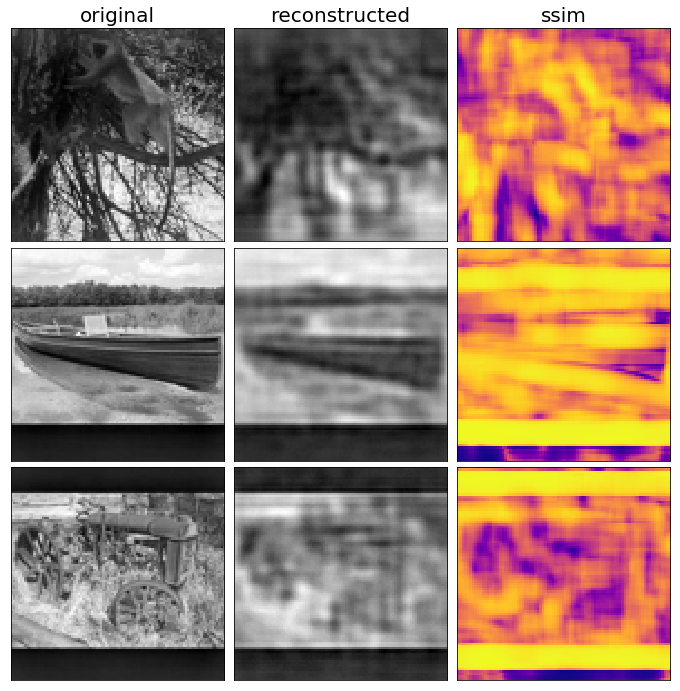

In [7]:
iqa.plot_sample(train_features, train_target)

In [8]:
weights = {}; biases = {};
for entry in ['weights1', 'weights2', 'weights3', 'weights4', 'weights_out']:
    temp = np.loadtxt('{}.txt'.format(entry))
    weights[entry] = temp
for entry in ['bias1', 'bias2', 'bias3', 'bias4', 'bias_out']:
    temp = np.loadtxt('{}.txt'.format(entry))
    biases[entry] = temp

In [11]:
weights['weights1'] = weights['weights1'].reshape((filter_dim,filter_dim,input_layer,first_layer))
weights['weights2'] = weights['weights2'].reshape((filter_dim2,filter_dim2,first_layer,second_layer))
weights['weights3'] = weights['weights3'].reshape((filter_dim2,filter_dim2,second_layer,third_layer))
weights['weights4'] = weights['weights4'].reshape((filter_dim2,filter_dim2,third_layer,fourth_layer))
weights['weights_out'] = weights['weights_out'].reshape((filter_dim2,filter_dim2,fourth_layer+third_layer+second_layer+first_layer,output_layer))

In [12]:
biases['bias1'] = biases['bias1'].reshape((first_layer))
biases['bias2'] = biases['bias2'].reshape((second_layer))
biases['bias3'] = biases['bias3'].reshape((third_layer))
biases['bias4'] = biases['bias4'].reshape((fourth_layer))
biases['bias_out'] = biases['bias_out'].reshape((output_layer))

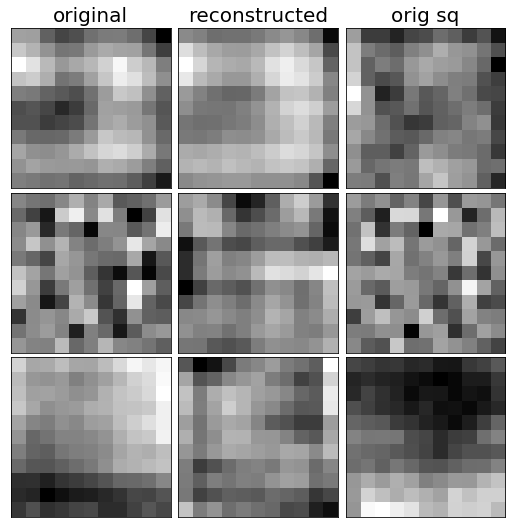

In [13]:
plt.figure(figsize = (9,9))
gs1 = gridspec.GridSpec(3, 3)
gs1.update(wspace=0, hspace=0.03)

for i in range(3):
    ax1, ax2, ax3 = plt.subplot(gs1[3*i]), plt.subplot(gs1[3*i+1]), plt.subplot(gs1[3*i+2])
    for ax in [ax1, ax2, ax3]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)    
    if i == 0:
        ax1.set_title('original', size=20)
        ax2.set_title('reconstructed', size=20)
        ax3.set_title('orig sq', size=20)
        
    x = np.random.randint(100)
    ax1.imshow(weights['weights1'][:,:,0,x], cmap='gray')
    ax2.imshow(weights['weights1'][:,:,1,x], cmap='gray')
    ax3.imshow(weights['weights1'][:,:,2,x], cmap='gray')
plt.show()

In [14]:
def convolve_inner_layers(x, W, b):
    '''
    inner layers of network --- tanh activation
    '''
    y = tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='VALID')
    y = tf.nn.bias_add(y, b)
    return tf.nn.tanh(y)

def convolve_ouput_layer(x, W, b):
    '''
    output layer of network --- linear activation
    '''
    y = tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='VALID')
    y = tf.nn.bias_add(y, b)
    return y

def conv_net(x, W, b):
    '''
    entire conv net. each layer feed to following layer as well as output layer
    '''
    conv1 = convolve_inner_layers(x, W['weights1'], b['bias1'])
    conv2 = convolve_inner_layers(conv1, W['weights2'], b['bias2'])
    conv3 = convolve_inner_layers(conv2, W['weights3'], b['bias3'])
    conv4 = convolve_inner_layers(conv3, W['weights4'], b['bias4'])
    output_feed = tf.concat([conv1, conv2, conv3, conv4],3)
    output = convolve_ouput_layer(output_feed, W['weights_out'], b['bias_out'])
    return output

In [15]:
sess = tf.Session()
test_im = np.reshape(train_features[:3,:,:,:], (3,96,96,4))
prediction = sess.run(conv_net(tf.cast(test_im, 'float32'), weights, biases))

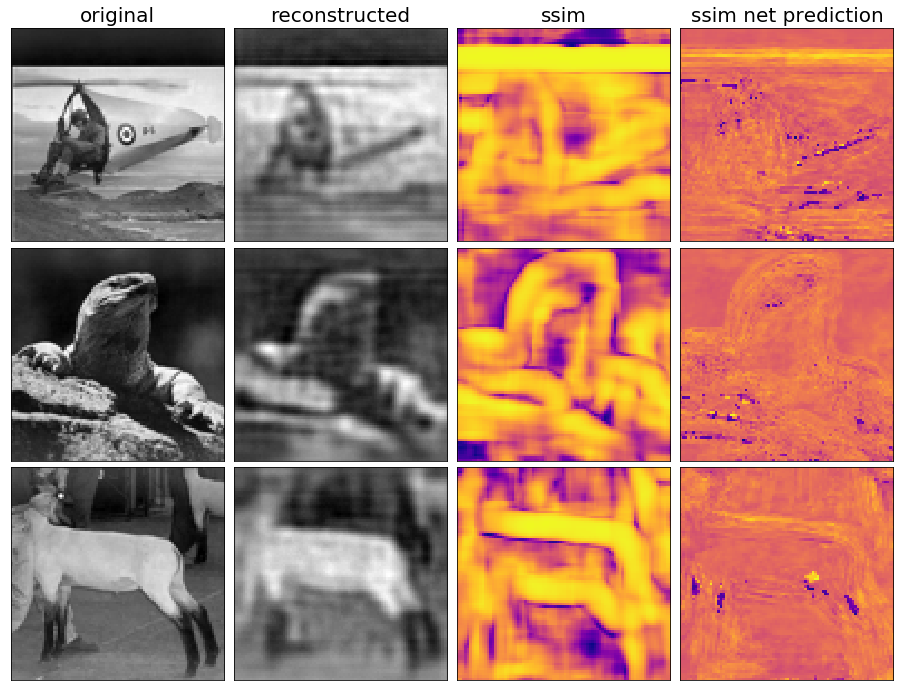

In [16]:
plt.figure(figsize = (16,12))
gs1 = gridspec.GridSpec(3, 4)
gs1.update(wspace=0, hspace=0.03)

for i in range(3):
    ax1, ax2, ax3, ax4 = plt.subplot(gs1[4*i]), plt.subplot(gs1[4*i+1]), plt.subplot(gs1[4*i+2]), plt.subplot(gs1[4*i+3])
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if i == 0:
        ax1.set_title('original', size=20)
        ax2.set_title('reconstructed', size=20)
        ax3.set_title('ssim', size=20)
        ax4.set_title('ssim net prediction', size=20)
        
    ax1.imshow(train_features[i,:,:,0], cmap='gray')
    ax2.imshow(train_features[i,:,:,1], cmap='gray')
    ax3.imshow(train_target[i,:,:,0], cmap='plasma')
    ax4.imshow(prediction[i,:,:,0], cmap='plasma')
    plt.savefig('prediction_demo1.png')
plt.show()